# Understanding Gradient Boosting Models
## SHAP values for Regression Models

To follow along directly:
1. Clone or download repo at https://github.com/numeristical/resources
2. Navigate to Folder `Understand_GB_Models`
3. Find this notebook `SHAP_Ames.ipynb`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score
import xgboost as xgb
import ml_insights as mli
import shap

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Understanding a Model

## Local Understanding with SHAP Values
- ### How did the model *arrive* at a particular prediction?
- ### Which feature values were most influential (in a particular prediction) and in what direction?
- ### How can gain global understanding by aggregating local explanations?
- ### How can I explore interactivity using SHAP values

    

## Ames Housing Data

Again, we'll use the Ames housing data and start by rebuilding the final model from the previous series ("Building a Model").

In [2]:
# Load in data, remove outliers, fill some NA with 0, add engineered feature
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)

df_house['BsmtFinSFtotal'] = df_house['BsmtFin SF 1']+df_house['BsmtFin SF 2']
df_house.BsmtFinSFtotal.fillna(0, inplace=True)

In [3]:
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [4]:
# Including the engineered feature
feat = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'BsmtFinSFtotal']



In [5]:
X = df_house.drop(['SalePrice'],axis=1) # everything except Sale Price
y = df_house.SalePrice 

In [6]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [7]:
# Expanded feature set with engineered feature
X_train = X_train_full.loc[:, feat]
X_test = X_test_full.loc[:, feat]

In [8]:
X_test.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Garage Area', 'Fireplaces', 'BsmtFinSFtotal'],
      dtype='object')

## Training a Model
We will take the best model we found from the Series "Building Gradient Boosting Models". 

In [9]:
best = {'colsample_bynode': 0.30000000000000004,
 'max_depth': 8,
 'reg_lambda': 1.4000000000000001,
 'subsample': 0.30000000000000004}
best

{'colsample_bynode': 0.30000000000000004,
 'max_depth': 8,
 'reg_lambda': 1.4000000000000001,
 'subsample': 0.30000000000000004}

In [10]:
xgb_final = xgb.XGBRegressor()
xgb_final.set_params(**best)
xgb_final.set_params(**{'learning_rate':.01,
                        'n_estimators': 10000,
                        'early_stopping_rounds':20},)
xgb_final.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
             verbose=False)
preds_final = xgb_final.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds_final))

18541.026859970538

In [11]:
# Get the mean of your target variable
np.mean(df_house.SalePrice), np.mean(y_train), np.mean(y_test)

(180411.5747008547, 180853.18297029703, 177623.9225)

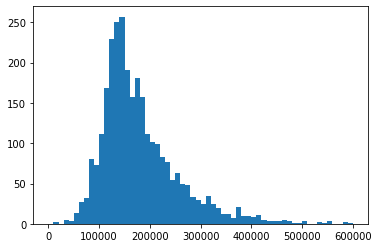

In [12]:
plt.hist(df_house.SalePrice, bins = np.linspace(0,600000,61));

## SHAP
- Based on Shapley value
- Assume the features are observed in a random order
- You update your prediction each time a feature is observed
- On average (over the random orderings of feature observations, for this particular prediction) how did your prediction change when observing that feature value.

In [13]:
tree_expl = shap.TreeExplainer(xgb_final)
sv = tree_expl(X_test)

In [14]:
# This is the "intercept", the prediction when you don't know any feature values
# Note it is close to (but not exactly) the mean SalePrice in the training data
sv.base_values.shape, sv.base_values[:10]

((400,),
 array([181005.77, 181005.77, 181005.77, 181005.77, 181005.77, 181005.77,
        181005.77, 181005.77, 181005.77, 181005.77], dtype=float32))

In [15]:
# These are the SHAP values of the 12 features (in the order they appear in X_train)
sv.values.shape

(400, 12)

In [16]:
# Lets put these together in a dataframe
sv_df = pd.DataFrame(sv.values, columns=X_train.columns)
sv_df['Intercept'] = sv.base_values

In [17]:
# Each row represents a prediction from the test set
# The sum of the values in each row is the final predicted value
sv_df.head()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Garage Area,Fireplaces,BsmtFinSFtotal,Intercept
0,6.420336,3315.794434,-1323.630371,12407.084961,2572.478516,16258.236328,3743.850342,0.802008,-989.414856,459.726074,4349.149414,-5883.151855,181005.765625
1,-3449.944580,-12471.906250,-7873.126953,-24607.265625,6429.943848,-16739.263672,-4371.500488,-441.890930,652.772705,-6511.605469,-5279.289062,2086.711182,181005.765625
2,-8387.253906,27173.123047,-711.120728,20973.390625,7220.601562,19941.683594,4585.015137,-6.051797,-748.604492,25085.582031,4548.043945,-16914.119141,181005.765625
3,1063.392822,-21539.017578,-1778.747437,-7660.923828,-7757.895508,-19499.783203,-3352.623535,-434.851959,-565.176636,-6772.213867,-5884.893555,-23.150267,181005.765625
4,-2518.280518,-23228.746094,5474.114746,-23372.884766,-10356.186523,-9876.000000,-3474.398438,-546.687256,273.498474,-4526.883789,-6418.863281,-9776.678711,181005.765625


## Explaining a particular prediction

In [18]:
ind=22
preds_final[ind]

206753.52

In [19]:
df_ex = pd.concat((X_test.iloc[ind],sv_df.iloc[ind,:]),axis=1)
df_ex.columns = ['feat_val','shap_val']
df_ex.sort_values(['shap_val'], ascending=False)

,feat_val,shap_val
Intercept,NaN,181005.765625
Year Built,2002.0,12264.048828
Gr Liv Area,1776.0,10789.271484
Lot Area,14006.0,10119.019531
Fireplaces,1.0,4257.595215
Full Bath,2.0,3837.422607
Year Remod/Add,2002.0,2898.665527
Overall Qual,7.0,2568.098145
Half Bath,1.0,-162.054108
Bedroom AbvGr,3.0,-924.772827


In [20]:
df_ex.shap_val.sum()

206753.36

In [21]:
shap.initjs()

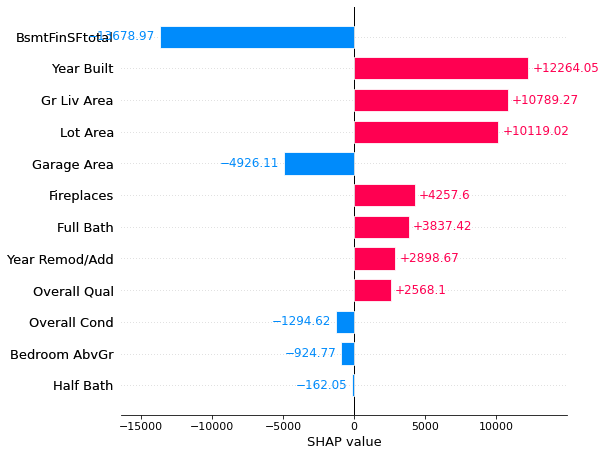

In [22]:
shap.plots.bar(sv[ind], max_display=15)

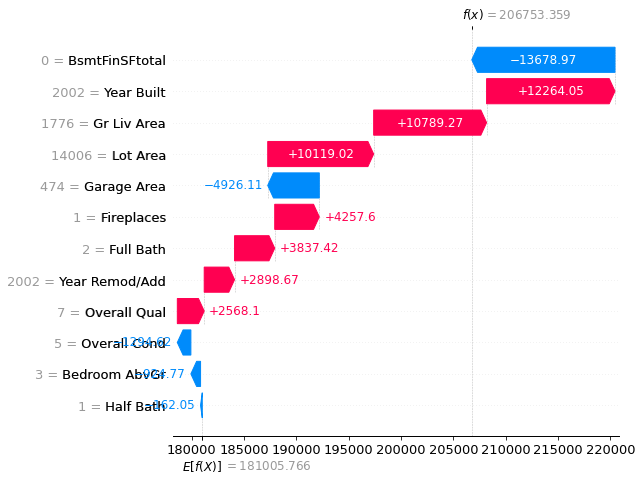

In [23]:
shap.plots.waterfall(sv[ind], max_display=15)

In [24]:
shap.force_plot(sv[ind])

## SHAP values for Global Understanding
Looking at the SHAP values (and their statistics) across a large set of data points (such as the test set) can help give a global understanding of the model

In [25]:
# Quick measure of feature importance - more meaningful than those based on splits
imp_series = sv_df.abs().mean().sort_values(ascending=False)
imp_series

Intercept         181005.765625
Gr Liv Area        18068.050781
Overall Qual       14281.824219
Year Built         12904.379883
BsmtFinSFtotal      9307.269531
Year Remod/Add      6423.663574
Fireplaces          6226.772461
Garage Area         6021.863770
Lot Area            5717.729980
Full Bath           4495.218750
Overall Cond        2974.270508
Bedroom AbvGr       1189.491089
Half Bath            642.520020
dtype: float32

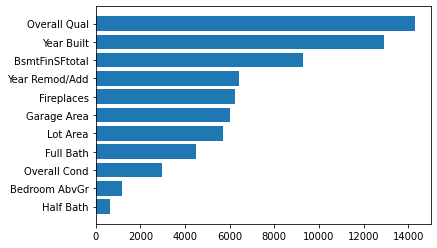

In [26]:
plt.barh(y=imp_series.index[:1:-1], width=imp_series.values[:1:-1]);

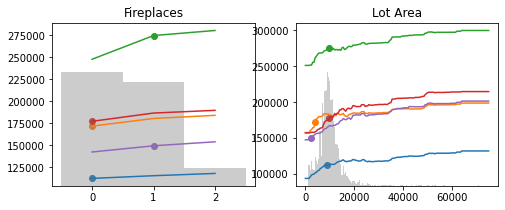

In [27]:
# How does this differ from ICE-plot
# What "could" impact model predictions vs what "does" impact them (in the data set)
rd= {'Fireplaces': np.arange(3), 'Lot Area': np.linspace(0,75000,150+1)}
mli.ice_plot(xgb_final, X_test.sample(5, random_state=3), ['Fireplaces', 'Lot Area'], rd, pred_fn='predict',
            show_hist=True, data_for_hist=X_train)

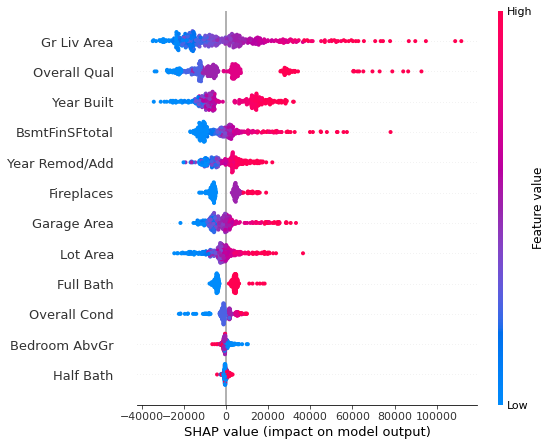

In [28]:
shap.summary_plot(sv)

## Exploring Interactivity using SHAP values

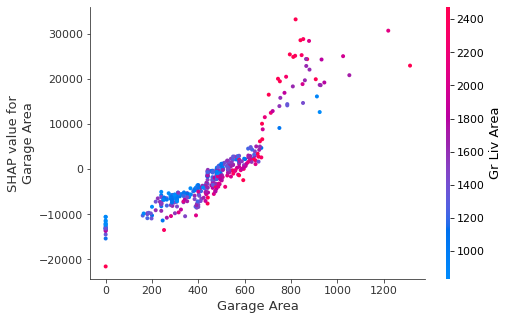

In [29]:
shap.dependence_plot('Garage Area',sv.values,X_test.to_numpy(), feature_names=X_test.columns,
                     interaction_index='Gr Liv Area')

# Thanks!!